<a href="https://colab.research.google.com/github/plumwiserim/Data-Analysis/blob/main/Class10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P02 :  주어진 전처리 과정과 문제를 해결하기 위해 데이터분석을 수행하세요. 

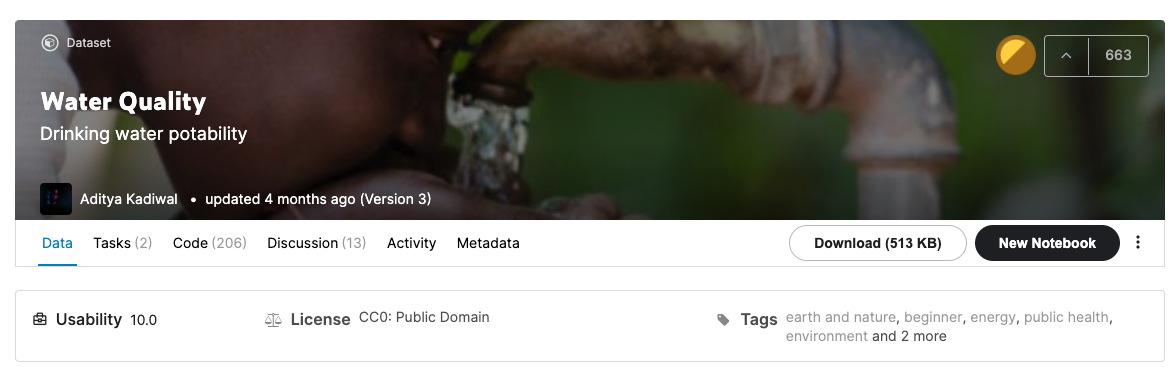

- 데이터셋 정보(Kaggle Dataset : water_quality)
- 참고 : https://www.kaggle.com/adityakadiwal/water-potability
  - ph : 물의 산과염기의 균형성
  - Hardness : 칼슘과 마그네슘에 의해 발생하는 물의 경도
  - Solids : Total dissolved solids - TDS : 미네랄 또는 염기를 용해하는 능력
  - Chloramines : 클로라민(리터당 최대 4밀리그램의 염소 수준이 안전한 수치) : 공공상수도 시슽메에서 사용되는 주요 소독제
  - Sulfate : 황산염
  - Conductivity : 전도도(전기 전도성)
  - Organic_carbon : 유기탄소
  - Trihalomethanes : 트리할로메탄 : 염소 처리된 물에서 발견될 수 있는 화학물질
  - Turbidity : 혼탁도
  - Potability : 사람이 섭취하기에 안전한지 여부 (1 : 음용가능, 0은 음용불가)

- 전처리 : 
  - 단계1 : Trihalomethanes(트리할로메탄)의 결측값을 제거하시오. 
  - 단계2 : 데이터 중 Potability별 Chloramines(클로라민)에 대한 이상치를 제거하시오
    - hint : Tukey 방식을 적용하여 제거
      - Q1: 제 1사분위수, Q3: 제 3사분위수, IQR: Q3 – Q1 일 때, 
      - (Y < Q1 - 1.5*IQR) or (Y > Q3 + 1.5*IQR) 이면 Y 이상치
  - 단계3 : 다음과 같은 조건으로 Turbidity_grade 파생변수를 생성하시오. 
    - 조건 : Turbidity(혼탁도)를 high( > 5.0), Low( < 3.5), medium(o/w)
  - 단계4 : 물의 산과염기의 균형성(ph)는 물의 식용여부를 결정짓는 중요한 변수로써 결측치가 없는 변수로써, 다음과 같은 선형식을 이용하여 결측치를 보정하시오(OLS적용)
    - 선형식 : ph = w1*Chloramines
  - 단계5 : Sulfate(황산염)의 결측값을 mean으로 채워 결측값을 해결하시오.
  - 단계6 : Potability, Turbidity_grade를 제외한 변수에 Standard Scaler를 적용하시오.

- 문제 : 물의 음용여부(Potability)를 예측하는 KNN 분류 모델을 만들고자 한다. 다음 절차에 따라 KNN 분류 모델을 생성하고 질문에 답하시오.
  - 다음 전처리를 수행한 후, 문제를 해결하세요.
    - 단계1 : Turbidity_grade(혼탁도 등급)에 대해 가변수(Dummay variable)를 생성하시오.
    - 단계2 : Potability 변수를 기준으로 결측치를 제외하고 Train과 Test 데이터를 분할하시오.
      -	Train Data : Test Data =8:2 으로 분리한다. 
      -	층화추출 적용하고, seed(random_state)는 47로 설정한다.
    - 단계3 : KNN Model생성(Train Data를 이용해 학습)
      - 독립변수 : ph, Hardness, Solids, Conductivity + 가변수(Turbidity_grade)
      - 분류 기준: Euclidean 거리를 이용하여 가까운 5개 이웃(Neighbor)의 음용여부(Potability)를 이용 
    - Test 데이터셋의 음용여부(Potability) 예측 시, 실제로는 음용가능하지만(Potability=”1”) 음용불가능하다고 예측한(predicted=”0”) 데이터의 건수는 몇 개인가?

In [ ]:
import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings('ignore')

In [ ]:
path = '/content/drive/MyDrive/A_부산대학교_데이터분석/kaggle_project/datasets/water_potability.csv'
df = pd.read_csv(path)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
df.sample(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
481,5.903466,201.864032,25394.104720,7.692154,313.648072,434.719747,18.006703,59.972160,4.587087,0
84,6.395359,133.834229,23827.275015,5.127747,266.908428,573.400295,9.833875,95.026609,4.191218,0
865,7.207931,204.010347,18493.872175,5.557864,311.568227,437.512042,12.994596,31.390450,4.705562,0


In [ ]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
df['ph'].isnull().sum()

491

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


## 전처리(PrePrcessing)


---
- 단계1 : Trihalomethanes(트리할로메탄)의 결측값을 제거하시오. 
---

In [ ]:
s1df = df.copy()

In [ ]:
s1df['Trihalomethanes'].isnull().sum()

162

In [ ]:
#s1df = s1df.dropna(subset=['Trihalomethanes'])
s1df.dropna(subset=['Trihalomethanes'], inplace=True)

In [ ]:
s1df['Trihalomethanes'].isnull().sum()

0

In [ ]:
s1df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2649 non-null   float64
 1   Hardness         3114 non-null   float64
 2   Solids           3114 non-null   float64
 3   Chloramines      3114 non-null   float64
 4   Sulfate          2373 non-null   float64
 5   Conductivity     3114 non-null   float64
 6   Organic_carbon   3114 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3114 non-null   float64
 9   Potability       3114 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 267.6 KB


---
- 단계2 : 데이터 중 Potability별 Chloramines(클로라민)에 대한 이상치를 제거하시오
  - hint : Tukey 방식을 적용하여 제거
    - Q1: 제 1사분위수, Q3: 제 3사분위수, IQR: Q3 – Q1 일 때, 
    - (Y < Q1 - 1.5*IQR) or (Y > Q3 + 1.5*IQR) 이면 Y 이상치
---

In [ ]:
s2df = s1df.copy()

In [ ]:
pd.pivot_table(s2df, index=['Potability', 'ph'])[['Hardness', 'Chloramines']]

Hardness  Chloramines
Potability ph                                
0          0.000000   214.846144     7.897539
           1.431782   228.130383     6.214773
           1.844538   233.764343     7.724432
           1.985383   216.480025     6.769268
           2.128531   192.696422     7.757770
...                          ...          ...
1          10.905076  207.004837     8.186479
           11.244507  169.403655     5.888460
           11.301794   77.459586     8.517986
           11.491011   94.812545     9.263166
           11.898078  228.132673     9.899637

[2597 rows x 2 columns]

In [ ]:
pd.pivot_table(s2df, index=['Potability'])

,Chloramines,Conductivity,Hardness,Organic_carbon,Solids,Sulfate,Trihalomethanes,Turbidity,ph
Potability,,,,,,,,,
0,7.107028,426.835125,196.554148,14.389207,21716.518343,334.165555,66.381060,3.960007,7.075971
1,7.178675,426.144269,196.008089,14.140175,22236.624969,333.133516,66.613838,3.974304,7.074424


In [ ]:
pd.pivot_table(s2df, index=['Potability'], values='Hardness', aggfunc='sum')

,Hardness
Potability,
0,365787.270197
1,234425.674471


In [ ]:
s2df.groupby(by=['Potability'])['Hardness'].sum()

Potability
0    365787.270197
1    234425.674471
Name: Hardness, dtype: float64

In [ ]:
def outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    #return data[(data > upper_bound) | (data < lower_bound)].index
    return ((data > upper_bound) | (data < lower_bound))

In [ ]:
outliers = s2df.groupby(by='Potability')['Chloramines'].apply(outliers_iqr)
outliers

0       False
1       False
2       False
3       False
4       False
        ...  
3270    False
3271    False
3273    False
3274    False
3275    False
Name: Chloramines, Length: 3114, dtype: bool

In [ ]:
outliers.value_counts()

False    3057
True       57
Name: Chloramines, dtype: int64

In [ ]:
s2df.loc[outliers] #Outlier

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
272,6.512737,229.263861,22475.046873,12.580026,192.033592,479.501279,9.983462,66.668576,4.612964,1
275,5.324942,280.089655,35344.658047,13.043806,180.206746,392.421496,10.504820,55.084668,4.427138,1
285,3.882631,243.807950,7751.809491,0.530351,NaN,341.291116,12.990592,60.109968,3.734001,1
287,10.003301,143.094285,46113.957485,12.912187,NaN,574.555041,16.963310,36.767671,4.746382,1
304,8.923981,135.938467,27919.770666,12.363285,NaN,415.629484,11.949914,69.314880,4.155583,1
351,8.848586,188.919983,32033.332019,13.127000,182.397370,479.791975,12.070444,77.671337,4.014682,1
408,6.443754,196.615992,25740.412591,2.484380,435.672765,352.353623,16.924419,33.051888,4.498685,1
434,6.143921,175.274076,29072.169654,12.062536,287.698157,469.983324,13.142493,83.279658,3.476213,0
437,9.462666,225.399307,12224.624604,2.981379,387.098720,485.697274,13.204394,62.297699,2.850184,0
454,8.534407,248.577482,22372.303267,2.993744,366.146249,341.760198,14.692902,78.708937,2.544734,0


In [ ]:
s2df.loc[~outliers] #Non- Outlier

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [ ]:
s2df = s2df.loc[~outliers] #Non- Outlier

In [ ]:
s2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2597 non-null   float64
 1   Hardness         3057 non-null   float64
 2   Solids           3057 non-null   float64
 3   Chloramines      3057 non-null   float64
 4   Sulfate          2331 non-null   float64
 5   Conductivity     3057 non-null   float64
 6   Organic_carbon   3057 non-null   float64
 7   Trihalomethanes  3057 non-null   float64
 8   Turbidity        3057 non-null   float64
 9   Potability       3057 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 262.7 KB


---
- 단계3 : 다음과 같은 조건으로 Turbidity_grade 파생변수를 생성하시오.
조건 : Turbidity(혼탁도)를 high( > 5.0), Low( < 3.5), medium(o/w)
---

In [ ]:
s3df = s2df.copy()

In [ ]:
s3df['Turbidity_grade']= np.where( s3df['Turbidity'] > 5.0, 'high', 
         np.where(s3df['Turbidity'] < 3.5, 'low', 'medium'))

In [ ]:
s3df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 0 to 3275
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2597 non-null   float64
 1   Hardness         3057 non-null   float64
 2   Solids           3057 non-null   float64
 3   Chloramines      3057 non-null   float64
 4   Sulfate          2331 non-null   float64
 5   Conductivity     3057 non-null   float64
 6   Organic_carbon   3057 non-null   float64
 7   Trihalomethanes  3057 non-null   float64
 8   Turbidity        3057 non-null   float64
 9   Potability       3057 non-null   int64  
 10  Turbidity_grade  3057 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 286.6+ KB


In [ ]:
s3df['Turbidity_grade'].value_counts()

medium    1936
low        833
high       288
Name: Turbidity_grade, dtype: int64

---
- 단계4 : 물의 산과염기의 균형성(ph)는 물의 식용여부를 결정짓는 중요한 변수로써 결측치가 없는 변수로써, 다음과 같은 선형식을 이용하여 결측치를 보정하시오(OLS적용)
  - 선형식 : ph = w1*Chloramines
---

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
s4df = s3df.copy()

In [ ]:
'''
결측치가 없는 종속변수 ph, Chloramines이 포함된 vars dataframe을 구성합니다.
선형회귀선의 Y와 X로 사용할 예정입니다.
'''
vars = s4df[ (~s4df['ph'].isnull()) & (~s4df['Chloramines'].isnull())]
vars.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Turbidity_grade
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0,medium
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0,low
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,medium
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,medium
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0,low


In [ ]:
vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2597 entries, 1 to 3275
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2597 non-null   float64
 1   Hardness         2597 non-null   float64
 2   Solids           2597 non-null   float64
 3   Chloramines      2597 non-null   float64
 4   Sulfate          1973 non-null   float64
 5   Conductivity     2597 non-null   float64
 6   Organic_carbon   2597 non-null   float64
 7   Trihalomethanes  2597 non-null   float64
 8   Turbidity        2597 non-null   float64
 9   Potability       2597 non-null   int64  
 10  Turbidity_grade  2597 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 243.5+ KB


In [ ]:
#먼저 2개의 변수값을 가져오기 위해서(X, Y변수) 설정
X = vars[['Chloramines']] #[[ ]] 이렇게 작성해야 함에 주의하세요.
Y = vars[['ph']]

model = LinearRegression(fit_intercept=False)
model.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [ ]:
'''
ph의 결측값 개수 확인
'''
s4df['ph'].isnull().sum()

460

In [ ]:
'''
ph의 결측값이 있는 row에서 Chloramines (X로 넣어줄 값)을 가져와서 예측값을 생성하고 결측값을 적용합니다.
'''
X = s4df.loc[(s4df['ph'].isnull()), ['Chloramines']]
s4df.loc[s4df['ph'].isnull(), ['ph']] = model.predict(X)

In [ ]:
s4df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 0 to 3275
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3057 non-null   float64
 1   Hardness         3057 non-null   float64
 2   Solids           3057 non-null   float64
 3   Chloramines      3057 non-null   float64
 4   Sulfate          2331 non-null   float64
 5   Conductivity     3057 non-null   float64
 6   Organic_carbon   3057 non-null   float64
 7   Trihalomethanes  3057 non-null   float64
 8   Turbidity        3057 non-null   float64
 9   Potability       3057 non-null   int64  
 10  Turbidity_grade  3057 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 286.6+ KB


---
- 단계5 : Sulfate(황산염)의 결측값을 mean으로 채워 결측값을 해결하시오.
---

In [ ]:
s5df = s4df.copy()

In [ ]:
s5df.loc[s5df['Sulfate'].isnull(), ['Sulfate']] = np.mean(s5df['Sulfate'])

In [ ]:
s5df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 0 to 3275
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3057 non-null   float64
 1   Hardness         3057 non-null   float64
 2   Solids           3057 non-null   float64
 3   Chloramines      3057 non-null   float64
 4   Sulfate          3057 non-null   float64
 5   Conductivity     3057 non-null   float64
 6   Organic_carbon   3057 non-null   float64
 7   Trihalomethanes  3057 non-null   float64
 8   Turbidity        3057 non-null   float64
 9   Potability       3057 non-null   int64  
 10  Turbidity_grade  3057 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 286.6+ KB


---
- 단계6 : Potability, Turbidity_grade를 제외한 변수에 Standard Scaler를 적용하시오.
---

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
s6df = s5df.copy()

In [ ]:
s6df = s6df.drop(columns = ['Potability', 'Turbidity_grade'])

In [ ]:
s6df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 0 to 3275
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3057 non-null   float64
 1   Hardness         3057 non-null   float64
 2   Solids           3057 non-null   float64
 3   Chloramines      3057 non-null   float64
 4   Sulfate          3057 non-null   float64
 5   Conductivity     3057 non-null   float64
 6   Organic_carbon   3057 non-null   float64
 7   Trihalomethanes  3057 non-null   float64
 8   Turbidity        3057 non-null   float64
dtypes: float64(9)
memory usage: 238.8 KB


In [ ]:
std_scaler = StandardScaler()

In [ ]:
result_scal = std_scaler.fit_transform(s6df)

In [ ]:
result_scal

array([[-0.0604607 ,  0.26166321, -0.1295432 , ..., -1.1791066 ,
         1.26608499, -1.29097691],
       [-2.13623443, -2.04795172, -0.37759941, ...,  0.26772149,
        -0.62586233,  0.68904658],
       [ 0.68785297,  0.85372386, -0.23074815, ...,  0.77668634,
        -0.00321093, -1.17147092],
       ...,
       [ 1.53860549, -0.62976677,  1.28955017, ..., -0.98039229,
         0.20814267, -0.85860989],
       [-1.22730183,  1.04859532, -1.14040791, ..., -0.94124646,
         0.67973125,  0.95691236],
       [ 0.5432333 , -0.03789438, -0.51829844, ...,  0.55718009,
         0.75440693, -2.13318223]])

In [ ]:
s6df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')

In [ ]:
s6_1df = pd.DataFrame(result_scal, columns=s6df.columns)
s6_1df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-0.060461,0.261663,-0.129543,0.113304,9.709177e-01,1.703532,-1.179107,1.266085,-1.290977
1,-2.136234,-2.047952,-0.377599,-0.342897,7.938969e-15,2.056951,0.267721,-0.625862,0.689047
2,0.687853,0.853724,-0.230748,1.468715,7.938969e-15,-0.098427,0.776686,-0.003211,-1.171471
3,0.828084,0.551880,0.011296,0.634099,6.460511e-01,-0.782835,1.249260,2.089871,0.854032
4,1.327728,-0.466376,-0.452325,-0.403713,-6.598168e-01,-0.348192,-0.823898,-2.127176,0.140982


In [ ]:
#스케일링을 위해 drop 시켰던 항목을 다시 채워줌으로써, 데이터셋을 완성시킵니다.
s6_1df[['Turbidity_grade', 'Potability']] = s5df[['Turbidity_grade', 'Potability']]
s6_1df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Turbidity_grade,Potability
0,-0.060461,0.261663,-0.129543,0.113304,9.709177e-01,1.703532,-1.179107,1.266085,-1.290977,low,0.0
1,-2.136234,-2.047952,-0.377599,-0.342897,7.938969e-15,2.056951,0.267721,-0.625862,0.689047,medium,0.0
2,0.687853,0.853724,-0.230748,1.468715,7.938969e-15,-0.098427,0.776686,-0.003211,-1.171471,low,0.0
3,0.828084,0.551880,0.011296,0.634099,6.460511e-01,-0.782835,1.249260,2.089871,0.854032,medium,0.0
4,1.327728,-0.466376,-0.452325,-0.403713,-6.598168e-01,-0.348192,-0.823898,-2.127176,0.140982,medium,0.0


In [ ]:
src_df = s6_1df.copy()

In [ ]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3057 non-null   float64
 1   Hardness         3057 non-null   float64
 2   Solids           3057 non-null   float64
 3   Chloramines      3057 non-null   float64
 4   Sulfate          3057 non-null   float64
 5   Conductivity     3057 non-null   float64
 6   Organic_carbon   3057 non-null   float64
 7   Trihalomethanes  3057 non-null   float64
 8   Turbidity        3057 non-null   float64
 9   Turbidity_grade  2850 non-null   object 
 10  Potability       2850 non-null   float64
dtypes: float64(10), object(1)
memory usage: 262.8+ KB


## 문제 : 물의 음용여부(Potability)를 예측하는 KNN 분류 모델을 만들고자 한다. 다음 절차에 따라 KNN 분류 모델을 생성하고 질문에 답하시오.
- 다음 전처리를 수행한 후, 문제를 해결하세요.
  - 단계1 : Turbidity_grade(혼탁도 등급)에 대해 가변수(Dummay variable)를 생성하시오.
  - 단계2 : Potability 변수를 기준으로 결측치를 제외하고 Train과 Test 데이터를 분할하시오.
    -	Train Data : Test Data =8:2 으로 분리한다. 
    -	층화추출 적용하고, seed(random_state)는 47로 설정한다.
  - 단계3 : KNN Model생성(Train Data를 이용해 학습)
    - 독립변수 : ph, Hardness, Solids, Conductivity + 가변수(Turbidity_grade)
    - 분류 기준: Euclidean 거리를 이용하여 가까운 5개 이웃(Neighbor)의 음용여부(Potability)를 이용 
  - Test 데이터셋의 음용여부(Potability) 예측 시, 실제로는 음용가능하지만(Potability=”1”) 음용불가능하다고 예측한(predicted=”0”) 데이터의 건수는 몇 개인가?

---
- 단계1 : Turbidity_grade(혼탁도 등급)에 대해 가변수(Dummay variable)를 생성하시오.
---

In [ ]:
q1 = src_df.copy()

In [ ]:
pd.get_dummies(q1, columns=['Turbidity_grade'], drop_first=True)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Turbidity_grade_low,Turbidity_grade_medium
0,-0.060461,0.261663,-0.129543,0.113304,9.709177e-01,1.703532,-1.179107,1.266085,-1.290977,0.0,1,0
1,-2.136234,-2.047952,-0.377599,-0.342897,7.938969e-15,2.056951,0.267721,-0.625862,0.689047,0.0,0,1
2,0.687853,0.853724,-0.230748,1.468715,7.938969e-15,-0.098427,0.776686,-0.003211,-1.171471,0.0,1,0
3,0.828084,0.551880,0.011296,0.634099,6.460511e-01,-0.782835,1.249260,2.089871,0.854032,0.0,0,1
4,1.327728,-0.466376,-0.452325,-0.403713,-6.598168e-01,-0.348192,-0.823898,-2.127176,0.140982,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3052,-0.619802,-0.296293,0.484205,0.420199,3.335986e-01,-0.132058,-0.670379,-0.373443,-0.381046,0.0,0,1
3053,-1.522827,-0.081369,2.945210,0.021666,7.315935e-01,1.234999,-0.119767,0.013301,0.605551,0.0,0,1
3054,1.538605,-0.629767,1.289550,0.147621,7.938969e-15,0.067773,-0.980392,0.208143,-0.858610,0.0,0,1
3055,-1.227302,1.048595,-1.140408,-0.570590,7.938969e-15,-0.292881,-0.941246,0.679731,0.956912,0.0,1,0


In [ ]:
qs1 = pd.get_dummies(q1, columns=['Turbidity_grade'], drop_first=True)

---
- 단계2 : Potability 변수를 기준으로 결측치를 제외하고 Train과 Test 데이터를 분할하시오.
    - Train Data : Test Data =8:2 으로 분리한다.
    - 층화추출 적용하고, seed(random_state)는 47로 설정한다.
---

In [ ]:
qs2 = qs1.copy()

In [ ]:
qs2.isnull().sum()

ph                          0
Hardness                    0
Solids                      0
Chloramines                 0
Sulfate                     0
Conductivity                0
Organic_carbon              0
Trihalomethanes             0
Turbidity                   0
Potability                207
Turbidity_grade_low         0
Turbidity_grade_medium      0
dtype: int64

In [ ]:
qs2.dropna(subset=['Potability'], inplace=True)

In [ ]:
qs2['Potability'].isnull().sum()

0

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Train, Test = train_test_split(qs2, test_size=0.2, random_state=47, stratify = qs2['Potability'])

In [ ]:
print(len(Train), len(Test))

2280 570


---
  - 단계3 : KNN 모델생성(Train Data를 이용해 학습)
    - 독립변수 : ph, Hardness, Solids, Conductivity + 가변수(Turbidity_grade)
    - 분류 기준: Euclidean 거리를 이용하여 가까운 5개 이웃(Neighbor)의 음용여부(Potability)를 이용
---

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2280 entries, 589 to 1210
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ph                      2280 non-null   float64
 1   Hardness                2280 non-null   float64
 2   Solids                  2280 non-null   float64
 3   Chloramines             2280 non-null   float64
 4   Sulfate                 2280 non-null   float64
 5   Conductivity            2280 non-null   float64
 6   Organic_carbon          2280 non-null   float64
 7   Trihalomethanes         2280 non-null   float64
 8   Turbidity               2280 non-null   float64
 9   Potability              2280 non-null   float64
 10  Turbidity_grade_low     2280 non-null   uint8  
 11  Turbidity_grade_medium  2280 non-null   uint8  
dtypes: float64(10), uint8(2)
memory usage: 200.4 KB


In [ ]:
X = ['ph', 'Hardness', 'Solids', 'Conductivity','Turbidity_grade_low', 'Turbidity_grade_medium']
Y = ['Potability']

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

In [ ]:
model = knn.fit(Train[X], Train[Y])

---
Test 데이터셋의 음용여부(Potability) 예측 시, 실제로는 음용가능하지만(Potability=”1”) 음용불가능하다고 예측한(predicted=”0”) 데이터의 건수는 몇 개인가?
---

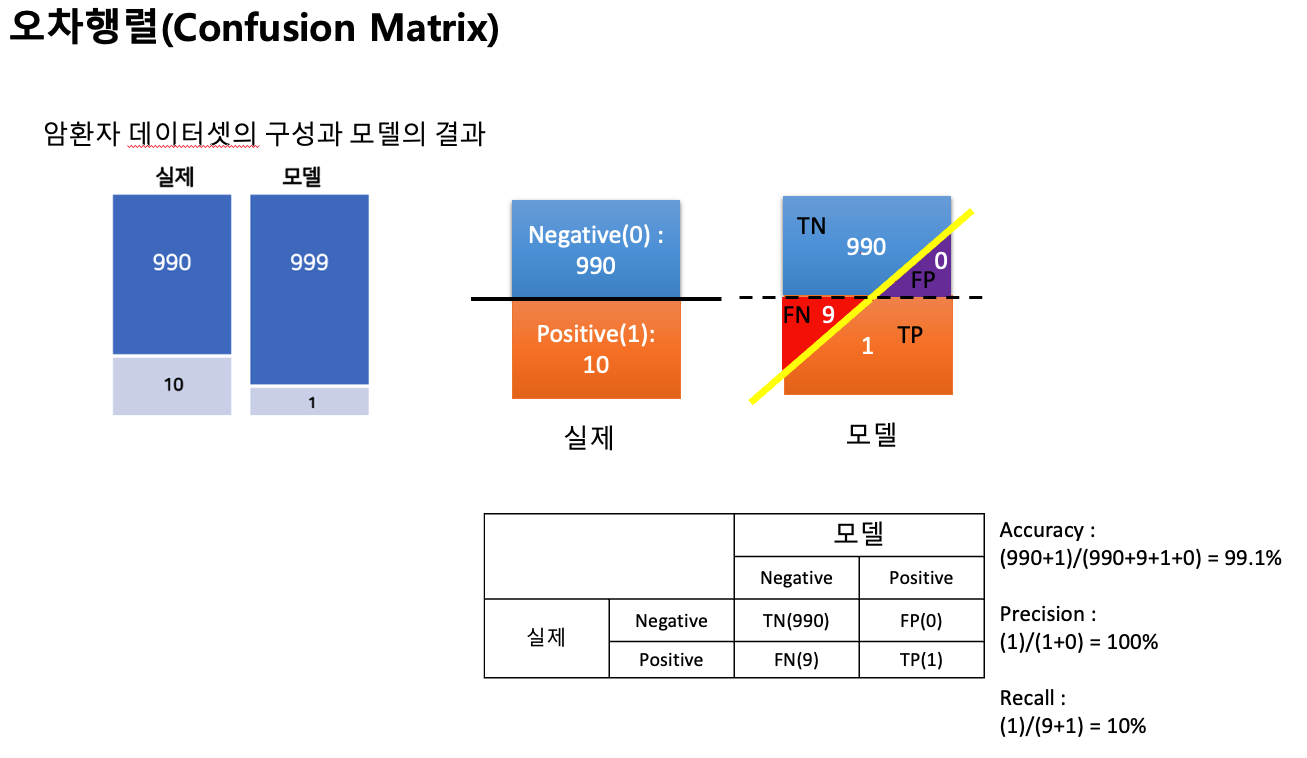

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
y_pred = model.predict(Test[X])

In [ ]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0.

In [ ]:
confusion_matrix(Test['Potability'], y_pred)

array([[270,  91],
       [150,  59]])

In [ ]:
#정답은 150

Recall = 59/(150+59)
Recall

0.2822966507177033

In [ ]:
'''
ROC-AUC Score
'''
from sklearn.metrics import roc_auc_score

In [ ]:
pred_y = model.predict_proba(Test[X])

In [ ]:
pred_y

array([[0.6, 0.4],
       [0.8, 0.2],
       [0.8, 0.2],
       ...,
       [0.6, 0.4],
       [0.8, 0.2],
       [0.4, 0.6]])

In [ ]:
pred_y.shape

(570, 2)

In [ ]:
roc_auc_score(Test['Potability'], pred_y[:, 1])

0.5046824324324325